##  Chapter 5- Automatic Outlier Detection for Numeric Data
### Introduction 
As you saw in the chapter 4, there are many variables where it is possible to specify a reasonable range for numeric values. When this is not possible, there are other tools in the data cleaning toolbox that you can use. Many of these methods look at the distribution of data values and identify values that appear to be outliers.

### Automatic Outlier Detection (Using Means and Standard Deviations)
If your data values have a distribution that looks similar to a normal distribution or at least is somewhat symmetrical (as determined by statistical techniques such as computing skewness and kurtosis or inspection of a histogram of the data), you might consider using properties of the distribution to help identify possible data errors. For example, you could decide to flag all values more than two standard deviations from the mean.

![title](img/3-sigma-rules.png)


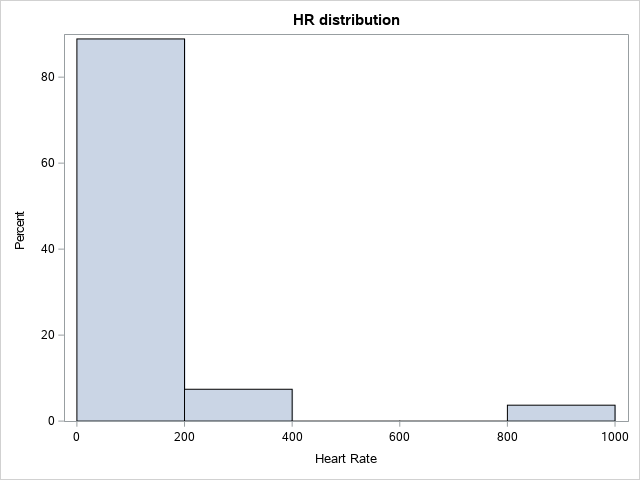

In [4]:

proc sgplot data=clean.patients;
  title "HR distribution";
  histogram Hr; 
  Run;

__Program 5.1: Detecting Outliers Based on the Standard Deviation__

In [2]:
libname Clean '/folders/myfolders/lectures'; 

*Use PROC MEANS to Output means and standard deviations to a data set;
proc means data=Clean.Patients noprint ;
   var HR;
   *where HR not in (900); 
   output out=Mean_Std(drop=_type_ _freq_)
          mean=
          std= / autoname;
run;

proc print data=Mean_Std; 
run;




Obs,HR_Mean,HR_StdDev
1,110.556,163.267


In [2]:
title "Outliers for HR Based on 2 Standard Deviations";
data _null_;
   file print;
   set Clean.Patients(keep=Patno HR );
   ***bring in the means and standard deviations;
   if _n_ = 1 then set Mean_Std;

   if HR lt HR_Mean - 2*HR_StdDev and not missing(HR)
      or HR gt HR_Mean + 2*HR_StdDev then put Patno= HR=;
run;

In [14]:
proc print data=Mean_Std; 
run;

Obs,HR_Mean,HR_StdDev
1,110.556,163.267


Comments: 

- The PROC MEANS step computes the mean and standard deviation for heart rate (HR). To compare each of the raw data values against the mean plus or minus 2 standard deviations, you need to add the values for the mean and standard deviation to each observation in the PATIENTS data set.

- You use the same trick you used earlier, that is, you execute a SET statement only once, when _N_ is equal to one. Because all the variables brought into the program data vector (PDV) with a SET statement are retained, the variables M_HR and S_HR will be in the PDV and will be added to each observation in the PATIENTS data set. The IF statement then checks for all values of HR that are more than 2 standard deviations from the mean (omitting missing values).

- The mean heart rate is about 100 and the standard deviation is about 160.
- If you have memorized all the data values in the PATIENTS data set, you will remember that there was one heart rate equal to 900. 
- That extreme value inflated the mean to over 100 and also inflated the standard deviation to over 160. 
- A good rule to remember is that extreme values can have a really devastating effect on the standard deviation. 
- The mean minus 2 standard deviations is a negative number (there were no negative heart rates) and the mean plus 2 standard deviations was over 400. That is the reason that only one heart rate (900) was detected by this program.

#### <font color=magenta> Q1. Activity </font> 


As you noticed the extreme value 900 for HR has inflated the mean to over 100 and also the standard deviation. Our goal here is to try to get more outliers. so let's calculate the mean and the standard deviation with excluding that extreme value. 
- Reuse proc means of program 5.1. by excluding the value 900 for HR (use where clause). 
- print the content of Mean_Std 
- Examine the mean value. 

Now we have the adjusted mean and standard deviation (without considering the extreme value 900), we want to flag all values more than two standard deviations from the adjusted mean as outliers. 
- Reuse the data null step code from program 5.1. as it is and show the output. 


### Detecting Outliers Based on a Trimmed Mean and Standard Deviation
- Run PROC RANK with the GROUPS= option to divide the data set into n groups. 
- if you want to trim 10% from the top and bottom of your data set, you would need to set GROUPS= equal to 10 and remove all the observations for HR in the top and bottom groups.

__Program 5.2: Computing Trimmed Statistics__

In [3]:
proc rank data=Clean.Patients(keep=Patno HR) out=Tmp groups=10;
   var HR;
   ranks grp_HR;
run;

proc sort data=tmp; 
by grp_HR; 
run; 

proc print data=Tmp ; 
run;




Obs,PATNO,HR,grp_HR
1,010,.,.
2,027,.,.
3,029,.,.
4,020,10,0
5,023,22,0
6,003,58,1
7,019,58,1
8,022,48,1
9,012,60,2
10,028,66,2


In [4]:
proc means data=Tmp noprint;
  *Trimming the top and bottom 10%;
   where grp_HR not in (0,9); 
   var HR;
   output out=Mean_Std_Trimmed(drop=_type_ _freq_)
          mean=
          std= / autoname;
run;
title 'mean and std after trimming'; 
proc print data=Mean_Std_Trimmed; 
run; 

Obs,HR_Mean,HR_StdDev
1,80.1304,30.6747


__Program 5.3: Listing Outliers Using Trimmed Statistics__

In [6]:
title "Outliers for HR Based on Trimmed Statistics";
data _null_;
   file print;
   set Clean.Patients(keep=Patno HR);
   ***bring in the means and standard deviations;
   if _n_ = 1 then set Mean_Std_Trimmed;
   *Adjust the standard deviation;
   Mult = 1.49;
   if HR lt HR_Mean - 2*Mult*HR_StdDev and not missing(HR)
      or HR gt HR_Mean + 2*Mult*HR_StdDev then put Patno= HR=;
run;

comments: 

- You are now identifying heart rates outside of two standard deviations of the mean where the mean and standard deviation were computed after trimming the heart rate values by 10%. But wait! What is that variable called Mult doing in the program? Here's the explanation:

- Even if you had normally distributed data, when you compute a standard deviation from trimmed data, you obtain a <font color="blue">smaller value</font> than if you use all the data values (<font color="blue">__since the trimmed data has less variation__</font>). 

- If you trimmed 10% of the data values from the top and bottom of the data and you had a variable that was normally distributed, your estimate of the standard deviation based on the trimmed data would be too small by a factor of 1.49. 

- If you want to base your decision to reject values beyond two standard deviations, you probably want to adjust the standard deviation you obtained from the trimmed data by that factor.

- This value will change depending on how much trimming is done. If you only trim a few percentage points from the top and bottom of the data values, the multiplier will be close to 1 and you can probably ignore it. If you trim a lot (say 25% from the top and bottom), this factor will be larger. The table below shows several trimming values, along with the appropriate MULT factors:

        Trim Value                     Multiplicative Factor
        (from the top and bottom) 
        5%                                      1.24
        10%                                     1.49
        20%                                     2.12
        25%                                     2.59

### Using the TRIM Option of PROC UNIVARIATE and ODS to Compute Trimmed Statistics
PROC UNIVARIATE has the ability to compute trimmed statistics. you can capture the trimmed values and place them in a SAS data set by using the ODS system. As an example, the following program will print statistics for Heart Rate (HR) with 10% of the values trimmed off both ends of the distribution:

__Program 5.4: Creating Trimmed Statistics Using PROC UNIVARIATE with the TRIM= Option__

In [10]:
libname Clean '/folders/myfolders/lectures'; 
ods output TrimmedMeans=Trimmed (keep=VarName Mean Stdmean df);

title;
proc univariate data=Clean.Patients trim=.1;
   var HR SBP DBP;
run;

ods output close;

- The  ODS statement requests that the trimmed statistics produced by PROC UNIVARIATE be sent to a data set that you have named TRIMMED. 
- Finally, the last  ODS statements close the OUTPUT destination (the SAS data set TRIMMED).
- Do not use the NOPRINT option of PROC UNIVARIATE to turn off the listing file. If you do so, the ODS OUTPUT statement will not be able to output anything to your SAS data set. 

- If the value of TRIM is an integer (from 0 to half the number of non-missing observations), this number of values are trimmed from the top and bottom of the data. If the TRIM value is a proportion between 0 and .5, this proportion of values will be trimmed from the top and bottom of the data. 


__Program 2-25: Using ODS to Capture Trimmed Statistics from PROC UNIVARIATE__

In [11]:
title; 
proc print data=TRIMMED; 
run;

Obs,VarName,Mean,StdMean,DF
1,HR,75.5714,3.692549,20
2,SBP,136.9,9.245110,19
3,DBP,84.9524,4.406425,20


The next problem you need to tackle is to restructure data set Patients so that you can merge it with data set Trimmed. Thus, the next block of code creates a separate observation for each patient and measure (HR, SBP, and DBP):

__Program 5.4: (continued)__

In [9]:
data Restructure;
   set Clean.Patients;
   length VarName $ 32;
   array Vars[*] HR SBP DBP;
   do i = 1 to dim(Vars);
      VarName = vname(Vars[i]);
      Value = Vars[i];
      output;
   end;
   *keep Patno VarName Value;
run;

proc print data=Restructure; 
run;

Obs,PATNO,GENDER,VISIT,HR,SBP,DBP,DX,AE,VarName,i,Value
1,,M,11/11/1998,90,190,100,,0,HR,1,90
2,,M,11/11/1998,90,190,100,,0,SBP,2,190
3,,M,11/11/1998,90,190,100,,0,DBP,3,100
4,001,M,11/11/1998,88,140,80,1,0,HR,1,88
5,001,M,11/11/1998,88,140,80,1,0,SBP,2,140
6,001,M,11/11/1998,88,140,80,1,0,DBP,3,80
7,002,F,11/13/1998,84,120,78,X,0,HR,1,84
8,002,F,11/13/1998,84,120,78,X,0,SBP,2,120
9,002,F,11/13/1998,84,120,78,X,0,DBP,3,78
10,002,F,11/13/1998,84,120,78,X,0,HR,1,84


- This section of code restructures the Patients data set so that it shares the variable VarName with data set Trimmed, thus allowing you to merge the two data sets using VarName as the BY variable. 
- One of the keys to this section of code is the VNAME function. This function takes an array element as its argument and returns the variable name associated with this array element. 

You can now sort both data sets (Trimmed and Restructure) by VarName and then merge the two data sets by VarName. The section of code below performs these operations:

__ Program 5.4: (continued)__

In [12]:
proc sort data=Trimmed;
   by VarName;
run;

proc sort data=Restructure;
   by VarName;
run;

data Outliers;
   merge Restructure Trimmed;
   by VarName;
   
   Std = StdMean*sqrt(DF + 1);

   if Value lt Mean - 2*Std and not
   missing(Value) then do;
      Reason = 'Low  ';
      output;
   end;

   else if Value gt Mean + 2*Std then do;
      Reason = 'High';
      output;
   end;
run;




All that is left to do is to sort data set Outliers by Patno so that the list of outliers will be in patient number order. 

__Program 5.4: (continued)__

In [13]:
proc sort data=outliers; 
    by value; 
run; 

title "Outliers based on trimmed Statistics"; 
proc print data=outliers; 
    id patno; 
    var varname value reason; 
run;

PATNO,VarName,Value,Reason
020,DBP,8,Low
020,HR,10,Low
011,DBP,20,Low
020,SBP,20,Low
023,HR,22,Low
023,SBP,34,Low
010,SBP,40,Low
009,DBP,180,High
321,DBP,200,High
017,HR,208,High


### Presenting a Macro Based on Trimmed Statistics ( optional)

One feature of the macro is that values for Trim (.1) and the number of standard deviations (2) are set as default values. You may ask, "How much should I trim my data?" If you believe that your data set is pretty clean, you might choose a small trim value such as .05 or .1. For data that could contain many errors or where the distributions are heavily skewed, you might need to trim by .2 or even .25. 

__Program 5.5: Presenting a Macro Based on Trimmed Statistics__


In [1]:
*Method using automatic outlier detection;
%macro Auto_Outliers(
   Dsn=,      /* Data set name                        */
   ID=,       /* Name of ID variable                  */
   Var_list=, /* List of variables to check           */
              /* separate names with spaces           */
   Trim=.1,   /* Integer 0 to n = number to trim      */
              /* from each tail; if between 0 and .5, */
              /* proportion to trim in each tail      */
   N_sd=2     /* Number of standard deviations        */);

   ods listing close;
   ods output TrimmedMeans=Trimmed(keep=VarName Mean Stdmean DF);
   proc univariate data=&Dsn trim=&Trim;
     var &Var_list;
   run;
   ods output close;

   data Restructure;
      set &Dsn;
      length VarName $ 32;
      array Vars[*] &Var_list;
      do i = 1 to dim(Vars);
         VarName = vname(Vars[i]);
         Value = Vars[i];
         output;
      end;
      keep &ID VarName Value;
   run;

   proc sort data=Trimmed;
      by VarName;
   run;

   proc sort data=restructure;
      by VarName;
   run;

   data Outliers;
      merge Restructure Trimmed;
      by VarName;
      Std = StdMean*sqrt(DF + 1);
      if Value lt Mean - &N_sd*Std and not missing(Value)
         then do;
            Reason = 'Low  ';
            output;
         end;
      else if Value gt Mean + &N_sd*Std
         then do;
         Reason = 'High';
         output;
      end;
   run;
   proc sort data=Outliers;
      by &ID;
   run;

   ods listing;
   title "Outliers Based on Trimmed Statistics";
   proc print data=Outliers;
      id &ID;
      var VarName Value Reason;
   run;

   proc datasets nolist library=work;
      delete Trimmed;
      delete Restructure;
   run;
   quit;
%mend Auto_Outliers;

SAS Connection established. Subprocess id is 20200



In [3]:
 libname Clean '/folders/myfolders/lectures'; 
 %Auto_Outliers(Dsn=Clean.Patients,
                   Id=Patno,
                   Var_List=HR SBP DBP,
                   Trim=.1,
                   N_Sd=2)

### Detecting Outliers Based on the Interquartile Range 

A box plot presents the minimum, 25th  percentile (1st quartile), 50th percentile (median), 75th percentile (3rd quartile),and maximum in a box and lines. 

How to find interquantiles: https://www.youtube.com/watch?v=R6VDj7pEG30

Outliers, if any, appear at the outsides of (adjacent) minimum and maxi
mum lines. As such, a box plot effectively summarizes these major percentiles using a box and lines. If a variable is normally distributed, its 25th  and 75th percentile are symmetric, and its median and mean are located at the same point ex
actly in the center of the box. 

#### Box plot: Display of Distribution
<table><tr><td><img src='http://www.physics.csbsju.edu/stats/simple.box.defs.gif'></td><td><img src='http://www.physics.csbsju.edu/stats/complex.box.defs.gif'></td></tr></table>


Yet another way to look for outliers is a method devised by advocates of exploratory data analysis (EDA).
- It uses the interquartile range (the distance from the 25th percentile to the 75th percentile) and defines an outlier as a multiple of the interquartile range above the 75th percentile or below the 25th percentile. 
- the first quartile (Q1) is the value corresponding to the 25th percentile (the value below which 25% of the data values lie). The third quartile (Q3) is the value corresponding to the 75% percentile. 
- For example, you might want to examine any data values more than 1.5 times the interquartile range above Q3 or 1.5 times the interquartile range below Q1 as outliers. 
- This is an attractive method because it is  <font color='red'> independent of the distribution of the data values </font>.


This simplest possible box plot displays the full range of variation (from min to max), the likely range of variation (the IQR), and a typical value (the median). Not uncommonly real datasets will display surprisingly high maximums or surprisingly low minimums called outliers. John Tukey has provided a precise definition for two types of outliers:  
- Outliers are either 3×IQR or more above the third quartile or 3×IQR or more below the first quartile. 
- Suspected outliers are are slightly more central versions of outliers: either 1.5×IQR or more above the third quartile or 1.5×IQR or more below the first quartile.
src: http://www.physics.csbsju.edu/stats/box2.html 
how to: https://www.wikihow.com/Calculate-Outliers

You can use PROC SGPLOT to display a box plot, a graphical display that uses EDA techniques. As an example, let's generate a box plot for SBP in the Patients data set:

__Program 5.6: Using PROC SGPLOT to Create a Box Plot__


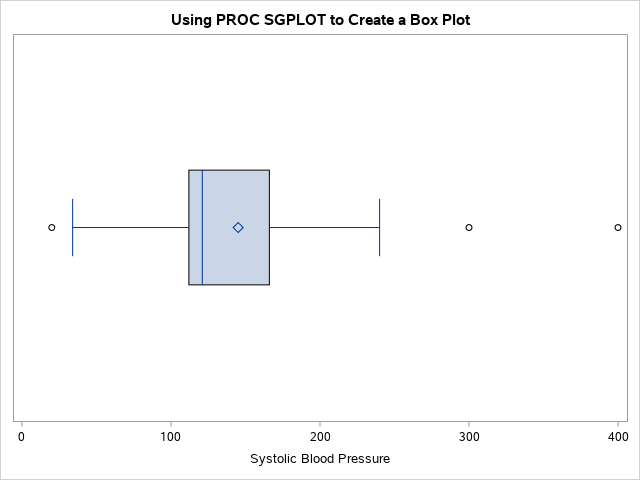

In [14]:
*Using PROC SGPLOT to Create a Box Plot for SBP;
title "Using PROC SGPLOT to Create a Box Plot";
proc sgplot data=clean.Patients(keep=Patno SBP);
   hbox SBP;
run;

- The vertical line in the center of the box is the median
- and the diamond inside the box represents the mean.
- The left side and the right side of the box represent the first and third quartiles, respectively. 
- The lines extending from both sides of the box represent a distance of 1.5 times the interquartile range from the sides of the box. (These lines are sometimes referred to as whiskers and the box plot is sometimes called a box-and-whisker plot.) 
- Finally, the circles represent possible outliers—data points more than 1.5 times the interquartile range below the first quartile or above the third quartile.

__Program 5.7: Creating a Box Plot for SBP for Each Level of Gender__

You can also use SGPLOT to display box plots at each level of a categorical variable. To demonstrate this, let's create a box plot of SBP for each level of Gender. Because there were a number of data errors for Gender, the program shown next restricts values of Gender to 'F' and 'M':


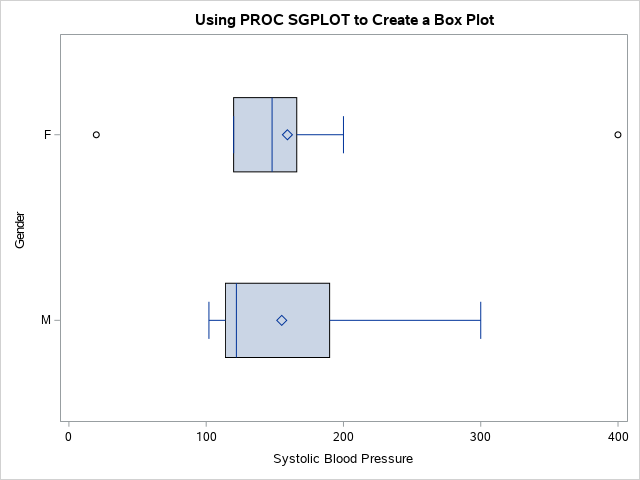

In [6]:
*Using PROC SGPLOT to Create a Box Plot for SBP;
title "Using PROC SGPLOT to Create a Box Plot";
proc sgplot data=clean.Patients(keep=Patno SBP Gender
                                where=(Gender in ('F','M')));
   hbox SBP / category=Gender;
run;

An easy way to determine the interquartile range and the first and third quartiles is to use PROC MEANS to output these quantities. The program below is similar to Program 5.1 except it uses a criterion based on the interquartile range instead of the standard deviation:

__Program 5.8: Detecting Outliers Using the Interquartile Range__

The keywords Q1, Q3, and QRange refer to the first quartile, the third quartile, and the interquartile range, respectively.

In [18]:
title "Outliers Based on Interquartile Range";
proc means data=Clean.Patients noprint;
   var HR;
   output out=Tmp
          Q1=
          Q3=
          QRange= / autoname;
run;

proc print data=Tmp; 
run;



Obs,_TYPE_,_FREQ_,HR_Q1,HR_Q3,HR_QRange
1,0,30,60,88,28


In [19]:
data _null_;
   file print;
   set Clean.Patients(keep=Patno HR);
   if _n_ = 1 then set Tmp;
   if HR le HR_Q1 - 1.5*HR_QRange and not missing(HR) or
      HR ge HR_Q3 + 1.5*HR_QRange then
      put "Possible Outlier for patient " Patno "Value of HR is " HR;
run;

#### <font color=magenta> Q2. Activity </font> 
the following  code is to reate a new dataset with deleting the outliers based on interquantile range. 

In [ ]:
title "Outliers Based on Interquartile Range";
proc means data=Clean.Patients noprint;
   var HR;
   output out=Tmp
          Q1=
          Q3=
          QRange= / autoname;
run;

data Clean.Patients_deletedOut;
   file print;
   set Clean.Patients(keep=Patno HR);
   if _n_ = 1 then set Tmp;
   if HR le HR_Q1 - 1.5*HR_QRange and not missing(HR) or
      HR ge HR_Q3 + 1.5*HR_QRange then
      delete;
run;

check for outliers on the Patients_deletedOut dataset using the interquartile  range method. Reuse the code in pg 5.8.